In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
bioqic = mre_pinn.data.BIOQICPhantom('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/phantom')

Loading ../data/BIOQIC/downloads/phantom_unwrapped_dejittered.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
    magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
    phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) float64
<xarray.Dataset>
Dimensions:    (frequency: 8, t: 8, x: 128, y: 80, z: 25, component: 3)
Coordinates:
  * frequency  (frequency) int64 30 40 50 60 70 80 90 100
  * t          (t) int64 0 1 2 3 4 5 6 7
  * x          (x) float64 0.0 0.0015 0.003 0.0045 ... 0.186 0.1875 0.189 0.1905
  * y          (y) float64 0.0 0.0015 0.003 0.0045 ... 0.114 0.1155 0.117 0.1185
  * z          (z) float64 0.0 0.0015 0.003 0.0045 ... 0.0315 0.033 0.0345 0.036
  * component  (component) <U1 'z' 'x' 'y'
Data variables:
    wave       (frequency, t, x, 

In [4]:
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/phantom', 80)
example.metadata

Loading ../data/BIOQIC/phantom/80/wave.nc
Loading ../data/BIOQIC/phantom/80/mre.nc
Loading ../data/BIOQIC/phantom/80/mre_mask.nc


size  spacing  origin   limit   center  extent
variable dimension                                                
wave     x           128   0.0015     0.0  0.1905  0.09525  0.1920
         y            80   0.0015     0.0  0.1185  0.05925  0.1200
         z            25   0.0015     0.0  0.0360  0.01800  0.0375
mre      x           128   0.0015     0.0  0.1905  0.09525  0.1920
         y            80   0.0015     0.0  0.1185  0.05925  0.1200
         z            25   0.0015     0.0  0.0360  0.01800  0.0375
mre_mask x           128   0.0015     0.0  0.1905  0.09525  0.1920
         y            80   0.0015     0.0  0.1185  0.05925  0.1200
         z            25   0.0015     0.0  0.0360  0.01800  0.0375

In [5]:
example.describe()

dtype     count                     mean  \
variable component                                                  
wave     z          complex128  256000.0  -7.79560900+6.72698600j   
         x          complex128  256000.0  11.60297600+5.97656100j   
         y          complex128  256000.0   12.9911150-60.1584800j   
mre      scalar     complex128  256000.0  5787.606492+212.755895j   
mre_mask scalar          int64  256000.0   0.61056600+0.00000000j   

                            std                      min  \
variable component                                         
wave     z           582.471380 -2376.969161+196.200381j   
         x           657.301744 -2175.073094+684.601065j   
         y          1462.968559 -2780.201300+395.164247j   
mre      scalar     5379.844267   0.00000000+0.00000000j   
mre_mask scalar        0.650332   0.00000000+0.00000000j   

                                       25%                       50%  \
variable component                                                     
wave     z         -234.616457+414.125869j  -19.609723+0156.3270410j   
         x         -224.405696+193.325240j   12.792270+0150.9914660j   
         y         -481.877988+192.813102j   38.712549+0211.1386550j   
mre      scalar     0.00000000+0.00000000j  10097.662129+358.617637j   
mre_mask scalar     0.00000000+0.00000000j  1.000000000+0.000000000j   

                                         75%                        max  
variable component                                                       
wave     z          212.5297830-151.8055140j  2306.8870920+337.1742710j  
         x          253.0384670-117.4608220j  2279.5158680-746.0839260j  
         y          508.4891050+341.2920960j  2894.1141370-511.8214990j  
mre      scalar     10097.662129+358.617637j  35183.797846+2546.696361j  
mre_mask scalar     1.000000000+0.000000000j   5.000000000+0.000000000j

<IPython.core.display.Javascript object>


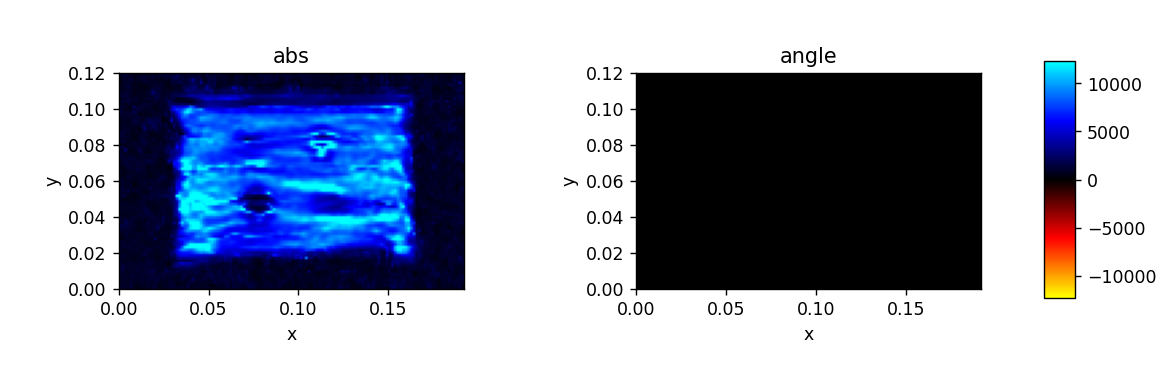

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [8]:
%autoreload
example.eval_baseline(frequency=example.wave.frequency.item(), polar=True)
example.view('base', ax_height=2, col='part', polar=True)

In [9]:
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=example.wave.frequency.item(), detach=True)

In [10]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=15,
    n_layers=4,
    n_hidden=128,
    polar_input=False,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (output): Linear(in_features=387, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (output): Linear(in_features=387, out_features=2, bias=True)
  )
)

In [11]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-8],
    pde_warmup_iters=5000,
    pde_init_weight=1e-8,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000278 s



In [12]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0008s (1.62%)
Model time/iter: 0.0067s (12.74%)
Loss time/iter:  0.0448s (85.63%)
Total time/iter: 0.0523s
Total time: 5.2297s
1k iters time: 0.87m
10k iters time: 8.72m
100k iters time: 1.45h


<IPython.core.display.Javascript object>


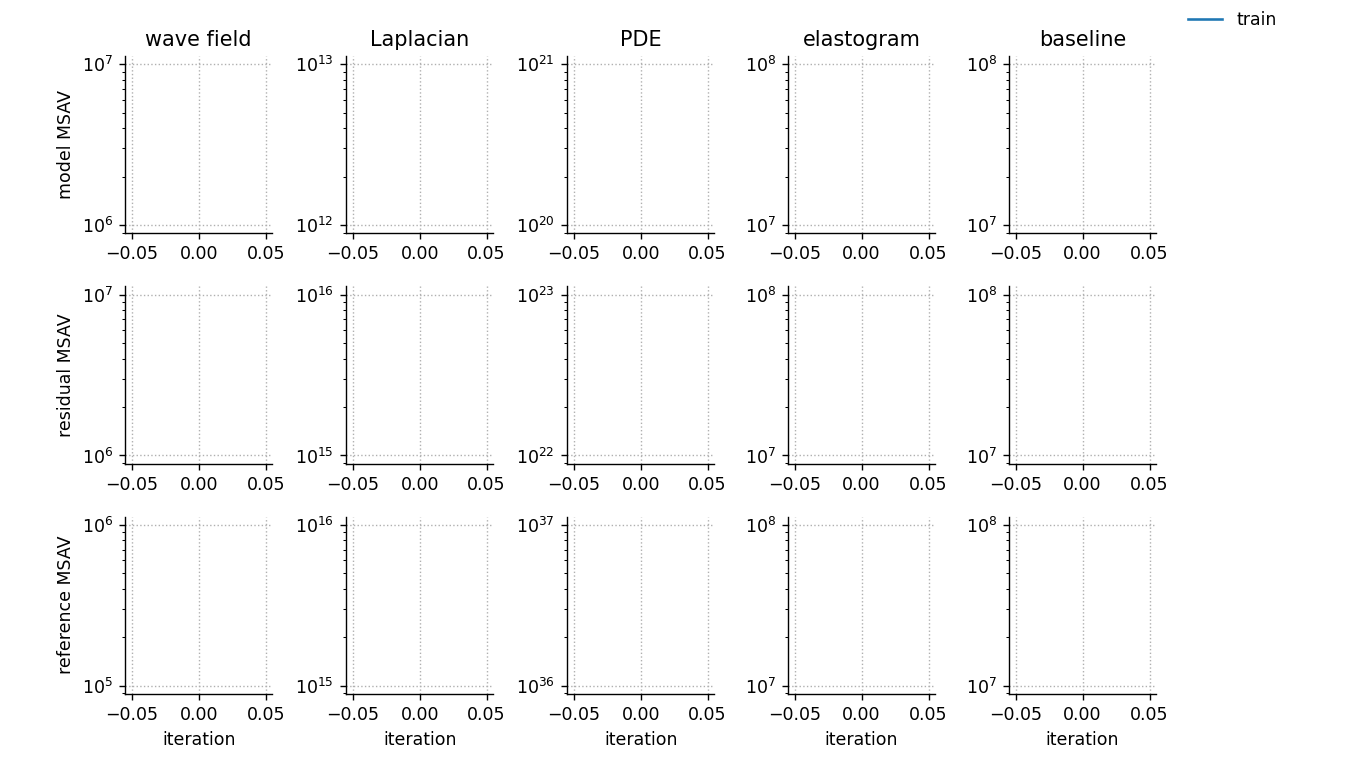

<IPython.core.display.Javascript object>


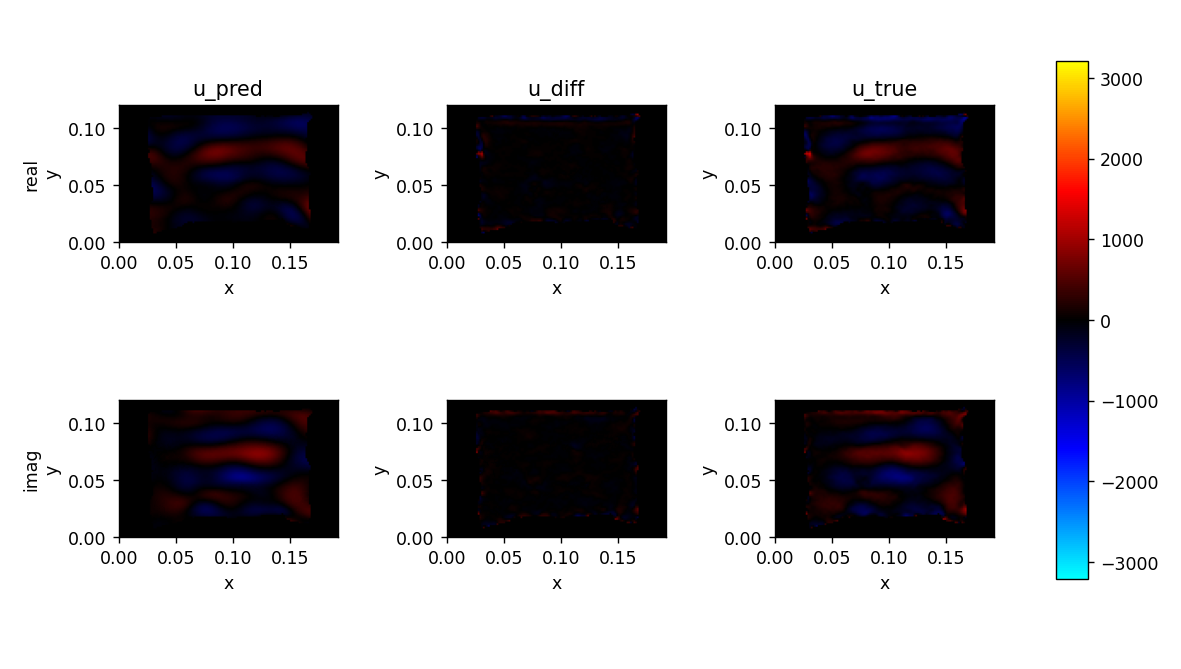

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


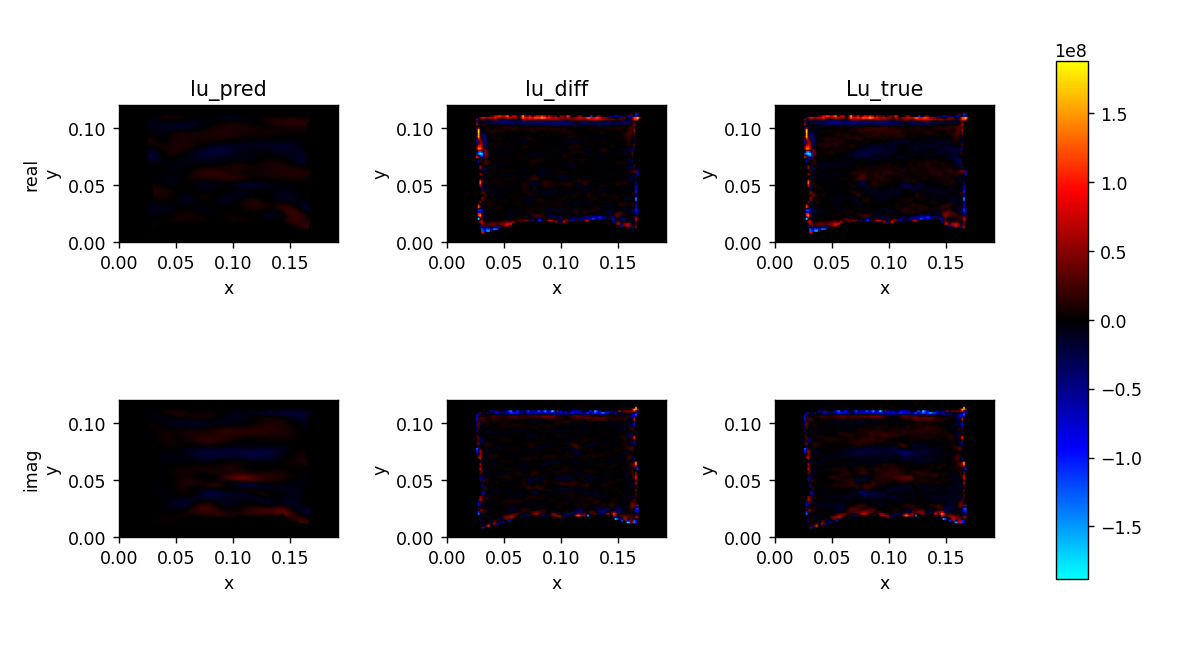

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


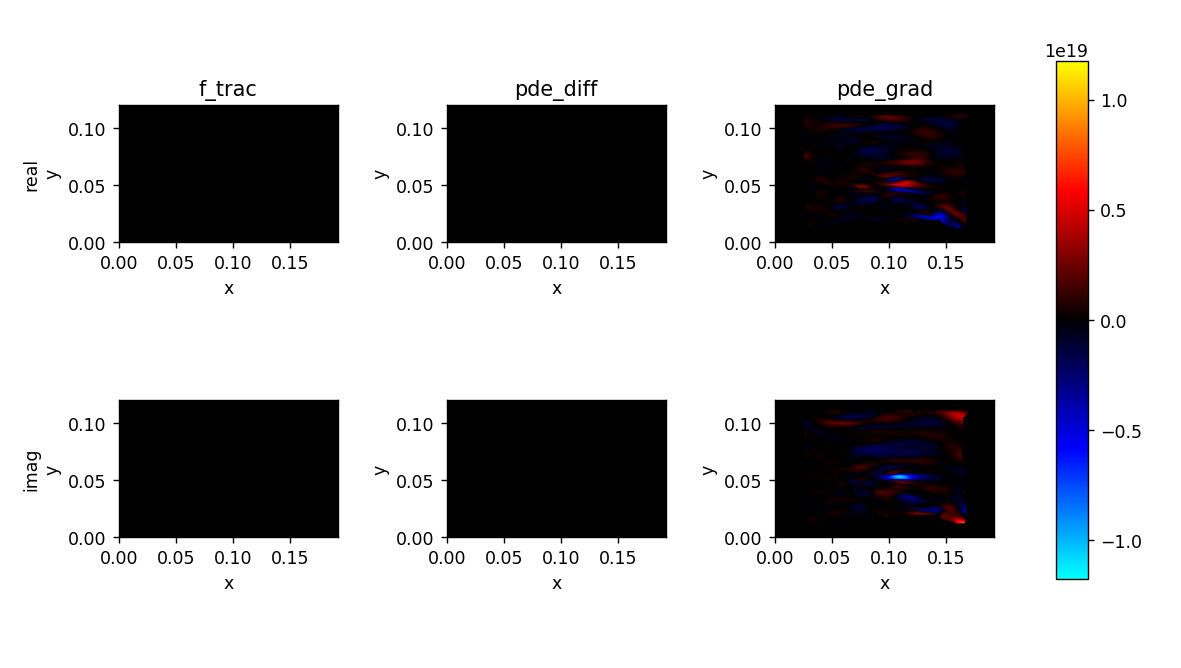

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


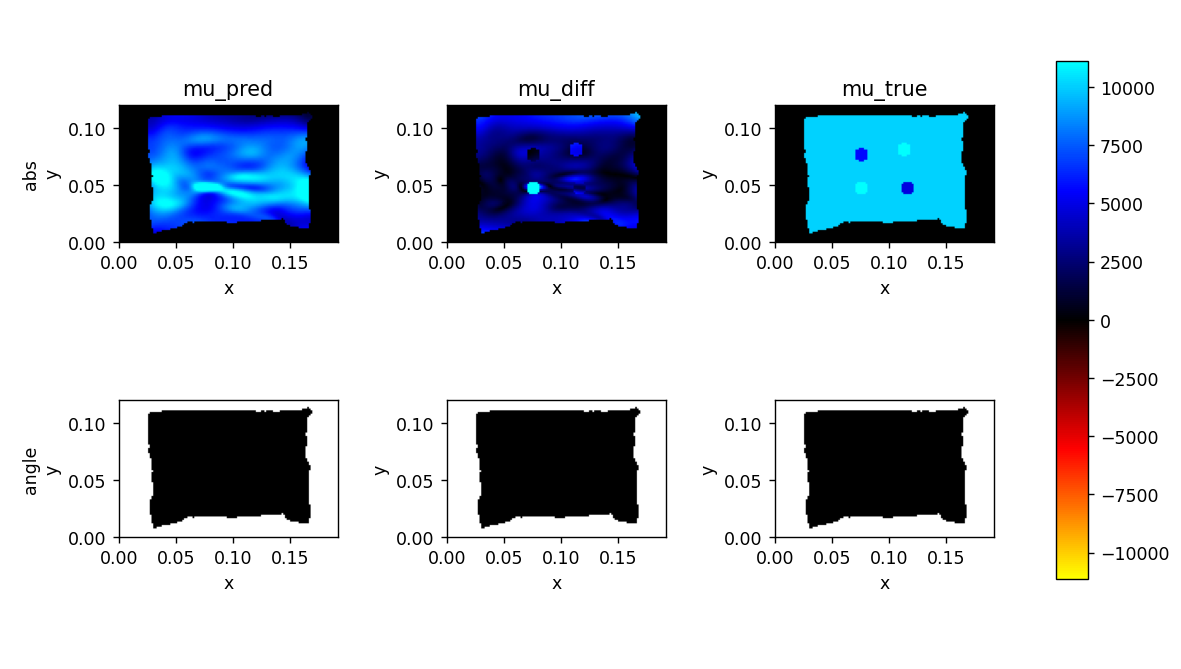

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


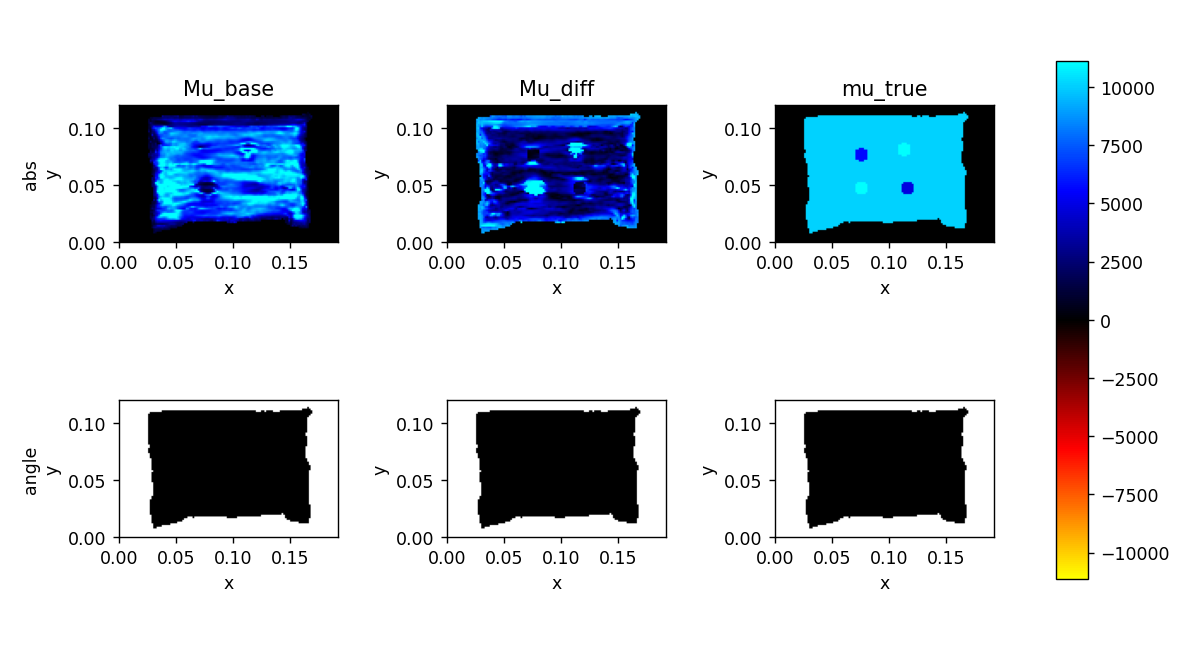

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [13]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.06e+06, 0.00e+00, 0.00e+00]    [4.04e+06, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


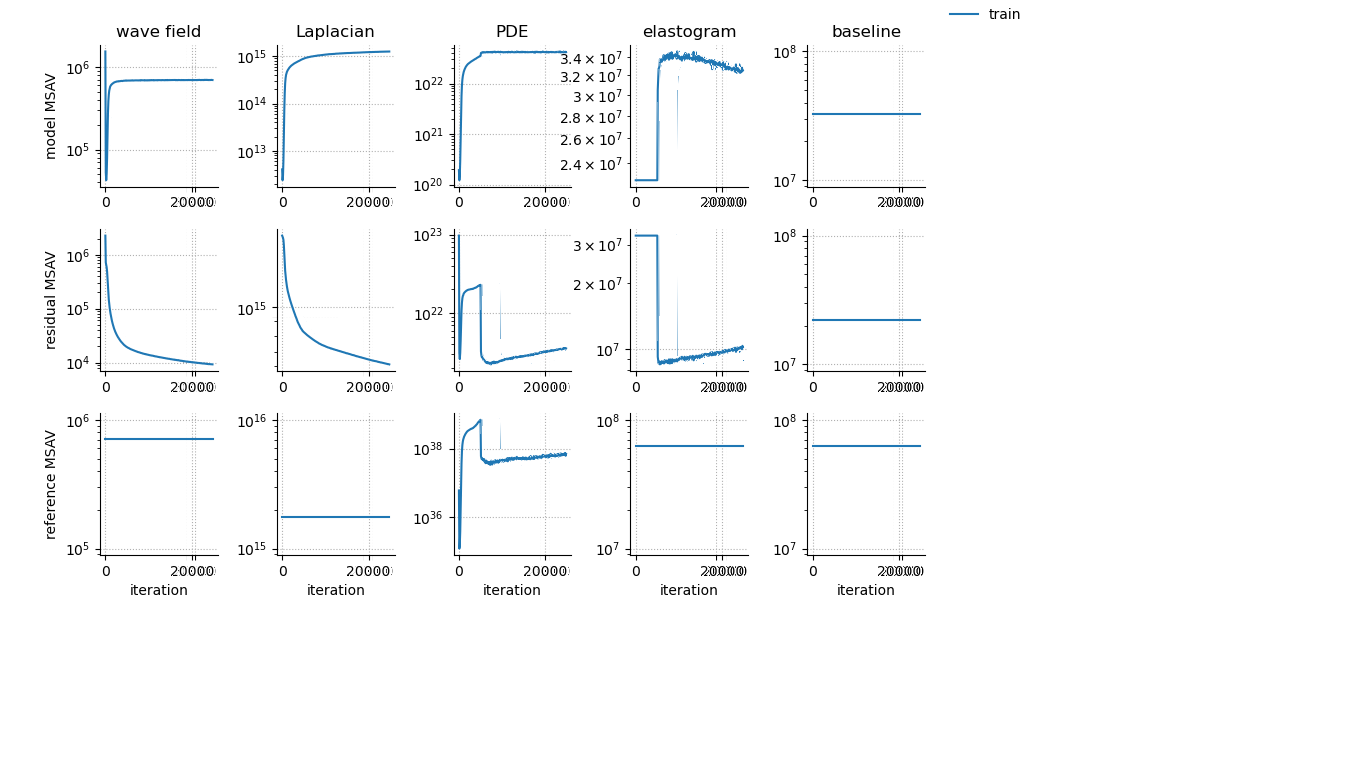

Time spent testing: 36.3616 (29.34%)
10        [2.51e+06, 0.00e+00, 0.00e+00]    [2.49e+06, 0.00e+00, 0.00e+00]    []  
20        [1.82e+06, 0.00e+00, 0.00e+00]    [1.89e+06, 0.00e+00, 0.00e+00]    []  
30        [1.56e+06, 0.00e+00, 0.00e+00]    [1.68e+06, 0.00e+00, 0.00e+00]    []  
40        [1.54e+06, 0.00e+00, 0.00e+00]    [1.55e+06, 0.00e+00, 0.00e+00]    []  
50        [1.36e+06, 0.00e+00, 0.00e+00]    [1.45e+06, 0.00e+00, 0.00e+00]    []  
60        [1.42e+06, 0.00e+00, 0.00e+00]    [1.40e+06, 0.00e+00, 0.00e+00]    []  
70        [1.37e+06, 0.00e+00, 0.00e+00]    [1.36e+06, 0.00e+00, 0.00e+00]    []  
80        [1.34e+06, 0.00e+00, 0.00e+00]    [1.33e+06, 0.00e+00, 0.00e+00]    []  
90        [1.29e+06, 0.00e+00, 0.00e+00]    [1.30e+06, 0.00e+00, 0.00e+00]    []  
100       [1.24e+06, 0.00e+00, 0.00e+00]    [1.28e+06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 35.9913 (43.69%)
110       [1.22e+06, 0.00e+00, 0.00e+00]    [1.26e+06, 0.00e+00, 0.00e+00]    []  
120       [1.

960       [1.82e+05, 0.00e+00, 0.00e+00]    [1.89e+05, 0.00e+00, 0.00e+00]    []  
970       [1.92e+05, 0.00e+00, 0.00e+00]    [1.86e+05, 0.00e+00, 0.00e+00]    []  
980       [1.85e+05, 0.00e+00, 0.00e+00]    [1.83e+05, 0.00e+00, 0.00e+00]    []  
990       [1.78e+05, 0.00e+00, 0.00e+00]    [1.79e+05, 0.00e+00, 0.00e+00]    []  
1000      [1.82e+05, 0.00e+00, 0.00e+00]    [1.78e+05, 0.00e+00, 0.00e+00]    []  
Time spent testing: 35.9536 (72.99%)
1010      [1.78e+05, 0.00e+00, 0.00e+00]    [1.74e+05, 0.00e+00, 0.00e+00]    []  
1020      [1.82e+05, 0.00e+00, 0.00e+00]    [1.72e+05, 0.00e+00, 0.00e+00]    []  
1030      [1.92e+05, 0.00e+00, 0.00e+00]    [1.70e+05, 0.00e+00, 0.00e+00]    []  
1040      [1.96e+05, 0.00e+00, 0.00e+00]    [1.68e+05, 0.00e+00, 0.00e+00]    []  
1050      [1.53e+05, 0.00e+00, 0.00e+00]    [1.65e+05, 0.00e+00, 0.00e+00]    []  
1060      [1.73e+05, 0.00e+00, 0.00e+00]    [1.63e+05, 0.00e+00, 0.00e+00]    []  
1070      [1.56e+05, 0.00e+00, 0.00e+00]    [1.60e

Time spent testing: 37.1268 (78.33%)
1910      [8.40e+04, 0.00e+00, 0.00e+00]    [7.70e+04, 0.00e+00, 0.00e+00]    []  
1920      [7.68e+04, 0.00e+00, 0.00e+00]    [7.70e+04, 0.00e+00, 0.00e+00]    []  
1930      [8.09e+04, 0.00e+00, 0.00e+00]    [7.61e+04, 0.00e+00, 0.00e+00]    []  
1940      [7.22e+04, 0.00e+00, 0.00e+00]    [7.56e+04, 0.00e+00, 0.00e+00]    []  
1950      [8.00e+04, 0.00e+00, 0.00e+00]    [7.53e+04, 0.00e+00, 0.00e+00]    []  
1960      [7.73e+04, 0.00e+00, 0.00e+00]    [7.46e+04, 0.00e+00, 0.00e+00]    []  
1970      [8.18e+04, 0.00e+00, 0.00e+00]    [7.46e+04, 0.00e+00, 0.00e+00]    []  
1980      [7.38e+04, 0.00e+00, 0.00e+00]    [7.37e+04, 0.00e+00, 0.00e+00]    []  
1990      [7.17e+04, 0.00e+00, 0.00e+00]    [7.34e+04, 0.00e+00, 0.00e+00]    []  
2000      [8.31e+04, 0.00e+00, 0.00e+00]    [7.29e+04, 0.00e+00, 0.00e+00]    []  
Time spent testing: 37.7531 (78.71%)
2010      [7.61e+04, 0.00e+00, 0.00e+00]    [7.25e+04, 0.00e+00, 0.00e+00]    []  
2020      [7.

2860      [5.10e+04, 0.00e+00, 0.00e+00]    [4.96e+04, 0.00e+00, 0.00e+00]    []  
2870      [4.97e+04, 0.00e+00, 0.00e+00]    [4.96e+04, 0.00e+00, 0.00e+00]    []  
2880      [5.72e+04, 0.00e+00, 0.00e+00]    [4.92e+04, 0.00e+00, 0.00e+00]    []  
2890      [4.88e+04, 0.00e+00, 0.00e+00]    [4.91e+04, 0.00e+00, 0.00e+00]    []  
2900      [5.04e+04, 0.00e+00, 0.00e+00]    [4.90e+04, 0.00e+00, 0.00e+00]    []  
Time spent testing: 37.2358 (80.66%)
2910      [5.24e+04, 0.00e+00, 0.00e+00]    [4.90e+04, 0.00e+00, 0.00e+00]    []  
2920      [5.48e+04, 0.00e+00, 0.00e+00]    [4.89e+04, 0.00e+00, 0.00e+00]    []  
2930      [5.14e+04, 0.00e+00, 0.00e+00]    [4.84e+04, 0.00e+00, 0.00e+00]    []  
2940      [5.17e+04, 0.00e+00, 0.00e+00]    [4.84e+04, 0.00e+00, 0.00e+00]    []  
2950      [5.24e+04, 0.00e+00, 0.00e+00]    [4.80e+04, 0.00e+00, 0.00e+00]    []  
2960      [5.46e+04, 0.00e+00, 0.00e+00]    [4.80e+04, 0.00e+00, 0.00e+00]    []  
2970      [5.65e+04, 0.00e+00, 0.00e+00]    [4.81e

Time spent testing: 35.5144 (81.73%)
3810      [3.77e+04, 0.00e+00, 0.00e+00]    [3.78e+04, 0.00e+00, 0.00e+00]    []  
3820      [3.85e+04, 0.00e+00, 0.00e+00]    [3.77e+04, 0.00e+00, 0.00e+00]    []  
3830      [4.13e+04, 0.00e+00, 0.00e+00]    [3.78e+04, 0.00e+00, 0.00e+00]    []  
3840      [4.19e+04, 0.00e+00, 0.00e+00]    [3.76e+04, 0.00e+00, 0.00e+00]    []  
3850      [4.03e+04, 0.00e+00, 0.00e+00]    [3.76e+04, 0.00e+00, 0.00e+00]    []  
3860      [3.95e+04, 0.00e+00, 0.00e+00]    [3.74e+04, 0.00e+00, 0.00e+00]    []  
3870      [3.97e+04, 0.00e+00, 0.00e+00]    [3.73e+04, 0.00e+00, 0.00e+00]    []  
3880      [4.25e+04, 0.00e+00, 0.00e+00]    [3.73e+04, 0.00e+00, 0.00e+00]    []  
3890      [4.27e+04, 0.00e+00, 0.00e+00]    [3.73e+04, 0.00e+00, 0.00e+00]    []  
3900      [3.76e+04, 0.00e+00, 0.00e+00]    [3.70e+04, 0.00e+00, 0.00e+00]    []  
Time spent testing: 36.2157 (81.80%)
3910      [3.92e+04, 0.00e+00, 0.00e+00]    [3.68e+04, 0.00e+00, 0.00e+00]    []  
3920      [3.

4760      [3.83e+04, 0.00e+00, 0.00e+00]    [3.16e+04, 0.00e+00, 0.00e+00]    []  
4770      [4.00e+04, 0.00e+00, 0.00e+00]    [3.15e+04, 0.00e+00, 0.00e+00]    []  
4780      [3.26e+04, 0.00e+00, 0.00e+00]    [3.15e+04, 0.00e+00, 0.00e+00]    []  
4790      [3.51e+04, 0.00e+00, 0.00e+00]    [3.16e+04, 0.00e+00, 0.00e+00]    []  
4800      [3.32e+04, 0.00e+00, 0.00e+00]    [3.17e+04, 0.00e+00, 0.00e+00]    []  
Time spent testing: 38.4015 (82.48%)
4810      [3.52e+04, 0.00e+00, 0.00e+00]    [3.15e+04, 0.00e+00, 0.00e+00]    []  
4820      [3.62e+04, 0.00e+00, 0.00e+00]    [3.15e+04, 0.00e+00, 0.00e+00]    []  
4830      [3.37e+04, 0.00e+00, 0.00e+00]    [3.14e+04, 0.00e+00, 0.00e+00]    []  
4840      [3.63e+04, 0.00e+00, 0.00e+00]    [3.11e+04, 0.00e+00, 0.00e+00]    []  
4850      [3.12e+04, 0.00e+00, 0.00e+00]    [3.16e+04, 0.00e+00, 0.00e+00]    []  
4860      [3.59e+04, 0.00e+00, 0.00e+00]    [3.12e+04, 0.00e+00, 0.00e+00]    []  
4870      [3.39e+04, 0.00e+00, 0.00e+00]    [3.14e

Time spent testing: 37.9123 (82.93%)
5710      [2.94e+04, 0.00e+00, 4.49e+13]    [2.84e+04, 0.00e+00, 4.53e+13]    []  
5720      [2.92e+04, 0.00e+00, 4.44e+13]    [2.86e+04, 0.00e+00, 4.52e+13]    []  
5730      [3.35e+04, 0.00e+00, 4.41e+13]    [2.83e+04, 0.00e+00, 4.54e+13]    []  
5740      [2.89e+04, 0.00e+00, 4.90e+13]    [2.83e+04, 0.00e+00, 4.62e+13]    []  
5750      [3.13e+04, 0.00e+00, 4.47e+13]    [2.84e+04, 0.00e+00, 4.70e+13]    []  
5760      [3.48e+04, 0.00e+00, 4.36e+13]    [2.86e+04, 0.00e+00, 4.58e+13]    []  
5770      [3.34e+04, 0.00e+00, 4.27e+13]    [2.83e+04, 0.00e+00, 4.60e+13]    []  
5780      [3.13e+04, 0.00e+00, 5.00e+13]    [2.85e+04, 0.00e+00, 4.59e+13]    []  
5790      [3.31e+04, 0.00e+00, 4.16e+13]    [2.80e+04, 0.00e+00, 4.55e+13]    []  
5800      [2.58e+04, 0.00e+00, 4.42e+13]    [2.82e+04, 0.00e+00, 4.64e+13]    []  
Time spent testing: 37.8045 (82.98%)
5810      [3.19e+04, 0.00e+00, 4.63e+13]    [2.80e+04, 0.00e+00, 4.53e+13]    []  
5820      [2.

6660      [3.04e+04, 0.00e+00, 4.06e+13]    [2.66e+04, 0.00e+00, 4.05e+13]    []  
6670      [3.04e+04, 0.00e+00, 4.38e+13]    [2.67e+04, 0.00e+00, 4.11e+13]    []  
6680      [2.92e+04, 0.00e+00, 4.13e+13]    [2.64e+04, 0.00e+00, 4.24e+13]    []  
6690      [2.95e+04, 0.00e+00, 4.29e+13]    [2.64e+04, 0.00e+00, 4.28e+13]    []  
6700      [3.01e+04, 0.00e+00, 3.98e+13]    [2.62e+04, 0.00e+00, 4.25e+13]    []  
Time spent testing: 38.7993 (83.29%)
6710      [3.08e+04, 0.00e+00, 4.04e+13]    [2.63e+04, 0.00e+00, 4.18e+13]    []  
6720      [3.04e+04, 0.00e+00, 3.85e+13]    [2.63e+04, 0.00e+00, 4.09e+13]    []  
6730      [3.05e+04, 0.00e+00, 4.29e+13]    [2.65e+04, 0.00e+00, 4.22e+13]    []  
6740      [3.12e+04, 0.00e+00, 4.25e+13]    [2.61e+04, 0.00e+00, 4.19e+13]    []  
6750      [2.97e+04, 0.00e+00, 4.10e+13]    [2.59e+04, 0.00e+00, 4.25e+13]    []  
6760      [2.31e+04, 0.00e+00, 3.82e+13]    [2.61e+04, 0.00e+00, 4.17e+13]    []  
6770      [2.77e+04, 0.00e+00, 4.19e+13]    [2.60e

Time spent testing: 37.9832 (83.56%)
7610      [2.95e+04, 0.00e+00, 4.11e+13]    [2.48e+04, 0.00e+00, 4.13e+13]    []  
7620      [2.86e+04, 0.00e+00, 4.05e+13]    [2.44e+04, 0.00e+00, 4.07e+13]    []  
7630      [2.90e+04, 0.00e+00, 4.22e+13]    [2.47e+04, 0.00e+00, 4.11e+13]    []  
7640      [3.10e+04, 0.00e+00, 4.04e+13]    [2.46e+04, 0.00e+00, 4.10e+13]    []  
7650      [2.42e+04, 0.00e+00, 3.97e+13]    [2.45e+04, 0.00e+00, 4.05e+13]    []  
7660      [3.01e+04, 0.00e+00, 4.10e+13]    [2.47e+04, 0.00e+00, 4.09e+13]    []  
7670      [2.91e+04, 0.00e+00, 3.91e+13]    [2.50e+04, 0.00e+00, 4.18e+13]    []  
7680      [2.78e+04, 0.00e+00, 3.79e+13]    [2.48e+04, 0.00e+00, 4.21e+13]    []  
7690      [2.72e+04, 0.00e+00, 3.99e+13]    [2.48e+04, 0.00e+00, 4.13e+13]    []  
7700      [2.64e+04, 0.00e+00, 4.04e+13]    [2.48e+04, 0.00e+00, 4.09e+13]    []  
Time spent testing: 38.8704 (83.57%)
7710      [2.96e+04, 0.00e+00, 4.50e+13]    [2.44e+04, 0.00e+00, 4.09e+13]    []  
7720      [2.

8560      [2.64e+04, 0.00e+00, 4.11e+13]    [2.32e+04, 0.00e+00, 4.17e+13]    []  
8570      [2.33e+04, 0.00e+00, 4.38e+13]    [2.33e+04, 0.00e+00, 4.25e+13]    []  
8580      [2.61e+04, 0.00e+00, 4.10e+13]    [2.36e+04, 0.00e+00, 4.16e+13]    []  
8590      [2.67e+04, 0.00e+00, 4.08e+13]    [2.37e+04, 0.00e+00, 4.36e+13]    []  
8600      [2.87e+04, 0.00e+00, 4.06e+13]    [2.35e+04, 0.00e+00, 4.20e+13]    []  
Time spent testing: 38.1356 (83.78%)
8610      [2.18e+04, 0.00e+00, 4.17e+13]    [2.35e+04, 0.00e+00, 4.20e+13]    []  
8620      [2.84e+04, 0.00e+00, 4.15e+13]    [2.35e+04, 0.00e+00, 4.19e+13]    []  
8630      [2.77e+04, 0.00e+00, 4.11e+13]    [2.35e+04, 0.00e+00, 4.23e+13]    []  
8640      [2.42e+04, 0.00e+00, 4.13e+13]    [2.31e+04, 0.00e+00, 4.14e+13]    []  
8650      [2.60e+04, 0.00e+00, 4.35e+13]    [2.32e+04, 0.00e+00, 4.26e+13]    []  
8660      [2.71e+04, 0.00e+00, 4.36e+13]    [2.34e+04, 0.00e+00, 4.21e+13]    []  
8670      [2.30e+04, 0.00e+00, 4.25e+13]    [2.34e

Time spent testing: 38.2441 (83.93%)
9510      [2.66e+04, 0.00e+00, 4.62e+13]    [2.22e+04, 0.00e+00, 4.42e+13]    []  
9520      [2.69e+04, 0.00e+00, 4.05e+13]    [2.27e+04, 0.00e+00, 4.45e+13]    []  
9530      [2.52e+04, 0.00e+00, 4.18e+13]    [2.26e+04, 0.00e+00, 4.34e+13]    []  
9540      [2.22e+04, 0.00e+00, 4.15e+13]    [2.24e+04, 0.00e+00, 4.38e+13]    []  
9550      [2.30e+04, 0.00e+00, 4.59e+13]    [2.25e+04, 0.00e+00, 4.37e+13]    []  
9560      [2.72e+04, 0.00e+00, 4.38e+13]    [2.23e+04, 0.00e+00, 4.36e+13]    []  
9570      [2.06e+04, 0.00e+00, 4.35e+13]    [2.23e+04, 0.00e+00, 4.28e+13]    []  
9580      [2.22e+04, 0.00e+00, 4.26e+13]    [2.24e+04, 0.00e+00, 4.38e+13]    []  
9590      [2.46e+04, 0.00e+00, 4.12e+13]    [2.23e+04, 0.00e+00, 4.37e+13]    []  
9600      [2.42e+04, 0.00e+00, 4.43e+13]    [2.23e+04, 0.00e+00, 4.46e+13]    []  
Time spent testing: 38.9972 (83.96%)
9610      [2.25e+04, 0.00e+00, 4.73e+13]    [2.23e+04, 0.00e+00, 4.29e+13]    []  
9620      [2.

10460     [2.63e+04, 0.00e+00, 4.62e+13]    [2.18e+04, 0.00e+00, 4.44e+13]    []  
10470     [1.97e+04, 0.00e+00, 4.43e+13]    [2.16e+04, 0.00e+00, 4.53e+13]    []  
10480     [2.34e+04, 0.00e+00, 4.54e+13]    [2.17e+04, 0.00e+00, 4.63e+13]    []  
10490     [2.52e+04, 0.00e+00, 4.65e+13]    [2.16e+04, 0.00e+00, 4.52e+13]    []  
10500     [2.41e+04, 0.00e+00, 4.58e+13]    [2.16e+04, 0.00e+00, 4.45e+13]    []  
Time spent testing: 38.3693 (84.08%)
10510     [1.94e+04, 0.00e+00, 4.28e+13]    [2.14e+04, 0.00e+00, 4.42e+13]    []  
10520     [2.79e+04, 0.00e+00, 4.72e+13]    [2.15e+04, 0.00e+00, 4.62e+13]    []  
10530     [2.50e+04, 0.00e+00, 4.64e+13]    [2.14e+04, 0.00e+00, 4.59e+13]    []  
10540     [2.76e+04, 0.00e+00, 4.49e+13]    [2.12e+04, 0.00e+00, 4.51e+13]    []  
10550     [2.29e+04, 0.00e+00, 4.66e+13]    [2.10e+04, 0.00e+00, 4.52e+13]    []  
10560     [2.36e+04, 0.00e+00, 4.48e+13]    [2.12e+04, 0.00e+00, 4.47e+13]    []  
10570     [2.47e+04, 0.00e+00, 4.51e+13]    [2.12e

Time spent testing: 38.3927 (84.19%)
11410     [2.22e+04, 0.00e+00, 4.45e+13]    [2.10e+04, 0.00e+00, 4.53e+13]    []  
11420     [2.40e+04, 0.00e+00, 4.80e+13]    [2.10e+04, 0.00e+00, 4.79e+13]    []  
11430     [2.16e+04, 0.00e+00, 4.31e+13]    [2.09e+04, 0.00e+00, 4.74e+13]    []  
11440     [2.23e+04, 0.00e+00, 4.56e+13]    [2.12e+04, 0.00e+00, 4.65e+13]    []  
11450     [2.42e+04, 0.00e+00, 4.67e+13]    [2.11e+04, 0.00e+00, 4.64e+13]    []  
11460     [2.51e+04, 0.00e+00, 4.72e+13]    [2.13e+04, 0.00e+00, 4.63e+13]    []  
11470     [2.83e+04, 0.00e+00, 4.78e+13]    [2.11e+04, 0.00e+00, 4.75e+13]    []  
11480     [1.99e+04, 0.00e+00, 4.79e+13]    [2.12e+04, 0.00e+00, 4.72e+13]    []  
11490     [2.07e+04, 0.00e+00, 5.31e+13]    [2.12e+04, 0.00e+00, 4.68e+13]    []  
11500     [2.05e+04, 0.00e+00, 4.55e+13]    [2.10e+04, 0.00e+00, 4.63e+13]    []  
Time spent testing: 38.6606 (84.20%)
11510     [2.28e+04, 0.00e+00, 4.65e+13]    [2.09e+04, 0.00e+00, 4.61e+13]    []  
11520     [2.

12360     [2.02e+04, 0.00e+00, 4.43e+13]    [2.04e+04, 0.00e+00, 4.71e+13]    []  
12370     [1.86e+04, 0.00e+00, 4.76e+13]    [2.05e+04, 0.00e+00, 4.76e+13]    []  
12380     [2.43e+04, 0.00e+00, 4.78e+13]    [2.05e+04, 0.00e+00, 4.71e+13]    []  
12390     [2.11e+04, 0.00e+00, 4.65e+13]    [2.05e+04, 0.00e+00, 4.76e+13]    []  
12400     [1.99e+04, 0.00e+00, 4.36e+13]    [2.04e+04, 0.00e+00, 4.62e+13]    []  
Time spent testing: 38.3294 (84.29%)
12410     [2.52e+04, 0.00e+00, 4.65e+13]    [2.03e+04, 0.00e+00, 4.78e+13]    []  
12420     [2.12e+04, 0.00e+00, 4.76e+13]    [2.05e+04, 0.00e+00, 4.85e+13]    []  
12430     [1.86e+04, 0.00e+00, 4.93e+13]    [2.03e+04, 0.00e+00, 4.72e+13]    []  
12440     [2.27e+04, 0.00e+00, 4.72e+13]    [2.02e+04, 0.00e+00, 4.85e+13]    []  
12450     [2.03e+04, 0.00e+00, 4.96e+13]    [2.04e+04, 0.00e+00, 4.83e+13]    []  
12460     [2.13e+04, 0.00e+00, 4.68e+13]    [2.01e+04, 0.00e+00, 4.74e+13]    []  
12470     [2.17e+04, 0.00e+00, 4.74e+13]    [2.03e

Time spent testing: 38.0357 (84.35%)
13310     [2.51e+04, 0.00e+00, 5.01e+13]    [1.97e+04, 0.00e+00, 4.81e+13]    []  
13320     [2.04e+04, 0.00e+00, 4.65e+13]    [1.95e+04, 0.00e+00, 4.87e+13]    []  
13330     [2.37e+04, 0.00e+00, 4.93e+13]    [1.97e+04, 0.00e+00, 4.93e+13]    []  
13340     [2.22e+04, 0.00e+00, 4.62e+13]    [1.98e+04, 0.00e+00, 4.88e+13]    []  
13350     [2.10e+04, 0.00e+00, 4.55e+13]    [1.97e+04, 0.00e+00, 4.79e+13]    []  
13360     [2.12e+04, 0.00e+00, 4.99e+13]    [1.98e+04, 0.00e+00, 4.85e+13]    []  
13370     [2.15e+04, 0.00e+00, 4.76e+13]    [2.00e+04, 0.00e+00, 4.91e+13]    []  
13380     [2.16e+04, 0.00e+00, 4.96e+13]    [1.98e+04, 0.00e+00, 4.80e+13]    []  
13390     [2.02e+04, 0.00e+00, 4.78e+13]    [1.99e+04, 0.00e+00, 4.90e+13]    []  
13400     [1.99e+04, 0.00e+00, 4.79e+13]    [1.96e+04, 0.00e+00, 4.88e+13]    []  
Time spent testing: 37.9848 (84.36%)
Time spent testing: 37.8929 (84.39%)
13710     [2.02e+04, 0.00e+00, 5.19e+13]    [1.97e+04, 0.00

14550     [1.95e+04, 0.00e+00, 4.72e+13]    [1.94e+04, 0.00e+00, 4.86e+13]    []  
14560     [2.12e+04, 0.00e+00, 4.83e+13]    [1.93e+04, 0.00e+00, 5.05e+13]    []  
14570     [2.25e+04, 0.00e+00, 4.87e+13]    [1.91e+04, 0.00e+00, 5.08e+13]    []  
14580     [2.04e+04, 0.00e+00, 5.33e+13]    [1.93e+04, 0.00e+00, 4.97e+13]    []  
14590     [1.92e+04, 0.00e+00, 5.10e+13]    [1.92e+04, 0.00e+00, 5.03e+13]    []  
14600     [1.98e+04, 0.00e+00, 4.81e+13]    [1.93e+04, 0.00e+00, 5.00e+13]    []  
Time spent testing: 38.5564 (84.45%)
14610     [2.28e+04, 0.00e+00, 4.76e+13]    [1.91e+04, 0.00e+00, 4.98e+13]    []  
14620     [2.03e+04, 0.00e+00, 5.02e+13]    [1.93e+04, 0.00e+00, 4.91e+13]    []  
14630     [1.96e+04, 0.00e+00, 5.05e+13]    [1.91e+04, 0.00e+00, 4.98e+13]    []  
14640     [1.76e+04, 0.00e+00, 5.06e+13]    [1.91e+04, 0.00e+00, 5.00e+13]    []  
14650     [1.65e+04, 0.00e+00, 4.90e+13]    [1.93e+04, 0.00e+00, 4.96e+13]    []  
14660     [2.01e+04, 0.00e+00, 4.97e+13]    [1.91e

15500     [2.05e+04, 0.00e+00, 5.25e+13]    [1.88e+04, 0.00e+00, 5.08e+13]    []  
Time spent testing: 38.4184 (84.51%)
15510     [1.96e+04, 0.00e+00, 4.87e+13]    [1.85e+04, 0.00e+00, 5.00e+13]    []  
15520     [2.07e+04, 0.00e+00, 5.04e+13]    [1.86e+04, 0.00e+00, 5.04e+13]    []  
15530     [1.75e+04, 0.00e+00, 5.27e+13]    [1.85e+04, 0.00e+00, 5.09e+13]    []  
15540     [2.01e+04, 0.00e+00, 4.98e+13]    [1.85e+04, 0.00e+00, 5.08e+13]    []  
15550     [2.05e+04, 0.00e+00, 4.89e+13]    [1.86e+04, 0.00e+00, 5.18e+13]    []  
15560     [2.06e+04, 0.00e+00, 5.18e+13]    [1.85e+04, 0.00e+00, 5.10e+13]    []  
15570     [2.38e+04, 0.00e+00, 5.15e+13]    [1.85e+04, 0.00e+00, 5.14e+13]    []  
15580     [1.77e+04, 0.00e+00, 4.99e+13]    [1.87e+04, 0.00e+00, 5.11e+13]    []  
15590     [1.28e+04, 0.00e+00, 5.02e+13]    [1.87e+04, 0.00e+00, 5.11e+13]    []  
15600     [2.16e+04, 0.00e+00, 4.98e+13]    [1.84e+04, 0.00e+00, 5.00e+13]    []  
Time spent testing: 38.6270 (84.52%)
15610     [1.

16450     [1.77e+04, 0.00e+00, 5.37e+13]    [1.84e+04, 0.00e+00, 5.33e+13]    []  
16460     [1.94e+04, 0.00e+00, 5.17e+13]    [1.84e+04, 0.00e+00, 5.24e+13]    []  
16470     [2.04e+04, 0.00e+00, 5.32e+13]    [1.84e+04, 0.00e+00, 5.21e+13]    []  
16480     [1.90e+04, 0.00e+00, 5.64e+13]    [1.83e+04, 0.00e+00, 5.24e+13]    []  
16490     [1.87e+04, 0.00e+00, 5.37e+13]    [1.82e+04, 0.00e+00, 5.16e+13]    []  
16500     [2.09e+04, 0.00e+00, 5.11e+13]    [1.82e+04, 0.00e+00, 5.11e+13]    []  
Time spent testing: 38.6412 (84.57%)
16510     [1.93e+04, 0.00e+00, 5.05e+13]    [1.80e+04, 0.00e+00, 5.14e+13]    []  
16520     [2.33e+04, 0.00e+00, 5.23e+13]    [1.83e+04, 0.00e+00, 5.19e+13]    []  
16530     [2.01e+04, 0.00e+00, 4.94e+13]    [1.83e+04, 0.00e+00, 5.17e+13]    []  
16540     [1.81e+04, 0.00e+00, 5.28e+13]    [1.82e+04, 0.00e+00, 5.17e+13]    []  
16550     [2.22e+04, 0.00e+00, 5.26e+13]    [1.84e+04, 0.00e+00, 5.22e+13]    []  
16560     [1.53e+04, 0.00e+00, 5.14e+13]    [1.82e

17400     [1.72e+04, 0.00e+00, 5.08e+13]    [1.80e+04, 0.00e+00, 5.30e+13]    []  
Time spent testing: 38.8241 (84.61%)
17410     [2.04e+04, 0.00e+00, 5.28e+13]    [1.78e+04, 0.00e+00, 5.33e+13]    []  
17420     [2.03e+04, 0.00e+00, 5.25e+13]    [1.78e+04, 0.00e+00, 5.29e+13]    []  
17430     [1.77e+04, 0.00e+00, 5.23e+13]    [1.80e+04, 0.00e+00, 5.24e+13]    []  
17440     [2.02e+04, 0.00e+00, 5.45e+13]    [1.81e+04, 0.00e+00, 5.23e+13]    []  
17450     [1.69e+04, 0.00e+00, 5.36e+13]    [1.80e+04, 0.00e+00, 5.32e+13]    []  
17460     [1.72e+04, 0.00e+00, 5.71e+13]    [1.81e+04, 0.00e+00, 5.36e+13]    []  
17470     [1.90e+04, 0.00e+00, 5.67e+13]    [1.82e+04, 0.00e+00, 5.39e+13]    []  
17480     [2.10e+04, 0.00e+00, 5.42e+13]    [1.81e+04, 0.00e+00, 5.35e+13]    []  
17490     [2.05e+04, 0.00e+00, 5.71e+13]    [1.82e+04, 0.00e+00, 5.41e+13]    []  
17500     [1.94e+04, 0.00e+00, 5.69e+13]    [1.80e+04, 0.00e+00, 5.32e+13]    []  
Time spent testing: 38.7536 (84.62%)
17510     [2.

18350     [1.81e+04, 0.00e+00, 5.50e+13]    [1.76e+04, 0.00e+00, 5.49e+13]    []  
18360     [1.79e+04, 0.00e+00, 5.27e+13]    [1.77e+04, 0.00e+00, 5.43e+13]    []  
18370     [2.01e+04, 0.00e+00, 4.99e+13]    [1.74e+04, 0.00e+00, 5.41e+13]    []  
18380     [1.80e+04, 0.00e+00, 5.57e+13]    [1.73e+04, 0.00e+00, 5.42e+13]    []  
18390     [1.85e+04, 0.00e+00, 5.65e+13]    [1.74e+04, 0.00e+00, 5.51e+13]    []  
18400     [1.96e+04, 0.00e+00, 5.68e+13]    [1.72e+04, 0.00e+00, 5.41e+13]    []  
Time spent testing: 39.4327 (84.66%)
18410     [1.99e+04, 0.00e+00, 5.71e+13]    [1.74e+04, 0.00e+00, 5.46e+13]    []  
18420     [1.74e+04, 0.00e+00, 5.82e+13]    [1.72e+04, 0.00e+00, 5.44e+13]    []  
18430     [2.11e+04, 0.00e+00, 5.58e+13]    [1.74e+04, 0.00e+00, 5.43e+13]    []  
18440     [1.85e+04, 0.00e+00, 5.56e+13]    [1.76e+04, 0.00e+00, 5.57e+13]    []  
18450     [1.82e+04, 0.00e+00, 4.91e+13]    [1.77e+04, 0.00e+00, 5.52e+13]    []  
18460     [2.05e+04, 0.00e+00, 5.40e+13]    [1.76e

19300     [2.10e+04, 0.00e+00, 5.46e+13]    [1.71e+04, 0.00e+00, 5.70e+13]    []  
Time spent testing: 38.9857 (84.71%)
19310     [1.50e+04, 0.00e+00, 5.58e+13]    [1.72e+04, 0.00e+00, 5.60e+13]    []  
19320     [1.64e+04, 0.00e+00, 5.18e+13]    [1.69e+04, 0.00e+00, 5.57e+13]    []  
19330     [1.92e+04, 0.00e+00, 5.55e+13]    [1.70e+04, 0.00e+00, 5.51e+13]    []  
19340     [2.07e+04, 0.00e+00, 5.38e+13]    [1.70e+04, 0.00e+00, 5.52e+13]    []  
19350     [1.61e+04, 0.00e+00, 5.67e+13]    [1.69e+04, 0.00e+00, 5.51e+13]    []  
19360     [1.96e+04, 0.00e+00, 5.51e+13]    [1.71e+04, 0.00e+00, 5.66e+13]    []  
19370     [1.61e+04, 0.00e+00, 5.87e+13]    [1.68e+04, 0.00e+00, 5.64e+13]    []  
19380     [2.01e+04, 0.00e+00, 5.56e+13]    [1.70e+04, 0.00e+00, 5.51e+13]    []  
19390     [2.11e+04, 0.00e+00, 5.28e+13]    [1.70e+04, 0.00e+00, 5.55e+13]    []  
19400     [2.00e+04, 0.00e+00, 5.70e+13]    [1.73e+04, 0.00e+00, 5.61e+13]    []  
Time spent testing: 39.0272 (84.72%)
19410     [1.

20250     [1.87e+04, 0.00e+00, 6.11e+13]    [1.67e+04, 0.00e+00, 5.72e+13]    []  
20260     [1.66e+04, 0.00e+00, 5.97e+13]    [1.69e+04, 0.00e+00, 5.73e+13]    []  
20270     [1.59e+04, 0.00e+00, 6.06e+13]    [1.70e+04, 0.00e+00, 5.76e+13]    []  
20280     [1.60e+04, 0.00e+00, 5.52e+13]    [1.66e+04, 0.00e+00, 5.80e+13]    []  
20290     [1.99e+04, 0.00e+00, 5.52e+13]    [1.68e+04, 0.00e+00, 5.76e+13]    []  
20300     [1.82e+04, 0.00e+00, 5.57e+13]    [1.69e+04, 0.00e+00, 5.64e+13]    []  
Time spent testing: 39.0134 (84.75%)
20310     [1.60e+04, 0.00e+00, 5.82e+13]    [1.66e+04, 0.00e+00, 5.68e+13]    []  
20320     [2.05e+04, 0.00e+00, 5.80e+13]    [1.68e+04, 0.00e+00, 5.76e+13]    []  
20330     [1.67e+04, 0.00e+00, 5.81e+13]    [1.68e+04, 0.00e+00, 5.78e+13]    []  
20340     [1.79e+04, 0.00e+00, 5.36e+13]    [1.67e+04, 0.00e+00, 5.65e+13]    []  
20350     [1.83e+04, 0.00e+00, 5.43e+13]    [1.66e+04, 0.00e+00, 5.71e+13]    []  
20360     [1.53e+04, 0.00e+00, 5.69e+13]    [1.67e

21200     [1.81e+04, 0.00e+00, 6.01e+13]    [1.67e+04, 0.00e+00, 5.99e+13]    []  
Time spent testing: 38.8802 (84.78%)
21210     [1.55e+04, 0.00e+00, 5.77e+13]    [1.65e+04, 0.00e+00, 5.85e+13]    []  
21220     [1.97e+04, 0.00e+00, 5.84e+13]    [1.63e+04, 0.00e+00, 5.89e+13]    []  
21230     [1.81e+04, 0.00e+00, 5.66e+13]    [1.63e+04, 0.00e+00, 5.89e+13]    []  
21240     [1.97e+04, 0.00e+00, 5.73e+13]    [1.63e+04, 0.00e+00, 5.82e+13]    []  
21250     [1.55e+04, 0.00e+00, 5.93e+13]    [1.64e+04, 0.00e+00, 5.86e+13]    []  
21260     [1.56e+04, 0.00e+00, 6.41e+13]    [1.65e+04, 0.00e+00, 5.75e+13]    []  
21270     [1.61e+04, 0.00e+00, 5.74e+13]    [1.66e+04, 0.00e+00, 5.79e+13]    []  
21280     [1.88e+04, 0.00e+00, 6.40e+13]    [1.64e+04, 0.00e+00, 5.96e+13]    []  
21290     [1.89e+04, 0.00e+00, 6.21e+13]    [1.66e+04, 0.00e+00, 6.01e+13]    []  
21300     [1.84e+04, 0.00e+00, 5.97e+13]    [1.64e+04, 0.00e+00, 5.86e+13]    []  
Time spent testing: 38.9495 (84.78%)
21310     [1.

22150     [1.79e+04, 0.00e+00, 5.57e+13]    [1.64e+04, 0.00e+00, 6.03e+13]    []  
22160     [1.52e+04, 0.00e+00, 5.86e+13]    [1.64e+04, 0.00e+00, 6.06e+13]    []  
22170     [1.97e+04, 0.00e+00, 6.21e+13]    [1.63e+04, 0.00e+00, 6.14e+13]    []  
22180     [1.97e+04, 0.00e+00, 6.07e+13]    [1.62e+04, 0.00e+00, 6.13e+13]    []  
22190     [1.80e+04, 0.00e+00, 5.53e+13]    [1.62e+04, 0.00e+00, 6.06e+13]    []  
22200     [1.59e+04, 0.00e+00, 5.47e+13]    [1.63e+04, 0.00e+00, 6.05e+13]    []  
Time spent testing: 38.8156 (84.81%)
22210     [1.82e+04, 0.00e+00, 5.61e+13]    [1.62e+04, 0.00e+00, 5.94e+13]    []  
22220     [1.45e+04, 0.00e+00, 5.56e+13]    [1.61e+04, 0.00e+00, 5.98e+13]    []  
22230     [1.46e+04, 0.00e+00, 5.99e+13]    [1.62e+04, 0.00e+00, 6.08e+13]    []  
22240     [1.61e+04, 0.00e+00, 6.21e+13]    [1.63e+04, 0.00e+00, 6.04e+13]    []  
22250     [1.87e+04, 0.00e+00, 6.02e+13]    [1.63e+04, 0.00e+00, 6.08e+13]    []  
22260     [1.75e+04, 0.00e+00, 6.39e+13]    [1.60e

23100     [1.72e+04, 0.00e+00, 6.09e+13]    [1.59e+04, 0.00e+00, 6.17e+13]    []  
Time spent testing: 38.8454 (84.84%)
23110     [1.44e+04, 0.00e+00, 6.04e+13]    [1.58e+04, 0.00e+00, 6.15e+13]    []  
23120     [1.83e+04, 0.00e+00, 6.74e+13]    [1.59e+04, 0.00e+00, 6.13e+13]    []  
23130     [1.51e+04, 0.00e+00, 6.20e+13]    [1.58e+04, 0.00e+00, 6.15e+13]    []  
23140     [1.74e+04, 0.00e+00, 5.82e+13]    [1.57e+04, 0.00e+00, 6.21e+13]    []  
23150     [1.92e+04, 0.00e+00, 6.71e+13]    [1.60e+04, 0.00e+00, 6.20e+13]    []  
23160     [1.79e+04, 0.00e+00, 6.05e+13]    [1.60e+04, 0.00e+00, 6.21e+13]    []  
23170     [2.04e+04, 0.00e+00, 6.73e+13]    [1.60e+04, 0.00e+00, 6.19e+13]    []  
23180     [1.57e+04, 0.00e+00, 5.74e+13]    [1.57e+04, 0.00e+00, 6.13e+13]    []  
23190     [1.48e+04, 0.00e+00, 6.01e+13]    [1.61e+04, 0.00e+00, 6.22e+13]    []  
23200     [1.70e+04, 0.00e+00, 6.69e+13]    [1.61e+04, 0.00e+00, 6.24e+13]    []  
Time spent testing: 38.7834 (84.84%)
23210     [1.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Time spent testing: 38.9622 (84.89%)
24510     [1.33e+04, 0.00e+00, 5.66e+13]    [1.54e+04, 0.00e+00, 6.38e+13]    []  
24520     [1.84e+04, 0.00e+00, 6.35e+13]    [1.55e+04, 0.00e+00, 6.37e+13]    []  
24530     [1.63e+04, 0.00e+00, 6.65e+13]    [1.55e+04, 0.00e+00, 6.39e+13]    []  
24540     [1.90e+04, 0.00e+00, 6.70e+13]    [1.59e+04, 0.00e+00, 6.23e+13]    []  
24550     [1.80e+04, 0.00e+00, 6.52e+13]    [1.57e+04, 0.00e+00, 6.34e+13]    []  
24560     [1.51e+04, 0.00e+00, 6.06e+13]    [1.57e+04, 0.00e+00, 6.40e+13]    []  
24570     [1.71e+04, 0.00e+00, 6.37e+13]    [1.57e+04, 0.00e+00, 6.31e+13]    []  
24580     [1.60e+04, 0.00e+00, 6.18e+13]    [1.57e+04, 0.00e+00, 6.23e+13]    []  
24590     [1.73e+04, 0.00e+00, 6.52e+13]    [1.57e+04, 0.00e+00, 6.31e+13]    []  
24600     [1.44e+04, 0.00e+00, 6.31e+13]    [1.56e+04, 0.00e+00, 6.32e+13]    []  
Time spent testing: 39.3645 (84.89%)
24610     [1.63e+04, 0.00e+00, 6.61e+13]    [1.56e+04, 0.00e+00, 6.28e+13]    []  
24620     [1.

In [ ]:
model.train(100000, display_every=10, callbacks=[test_eval])